In [64]:
import os
import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_model_optimization as tfmot

In [65]:
# read and prepare single image for prediction
def read_rgb(fname, sz=80):
    img = tf.keras.preprocessing.image.load_img(fname,
        color_mode='rgb', target_size=(sz,sz), interpolation='bilinear')
    data = tf.keras.preprocessing.image.img_to_array(img)
    return data.reshape((1, 80, 80, 3)) / 256.0

## Construct Fully-convolutional network

In [66]:
# load classifier
model = tf.keras.models.load_model('patch-classifier')
temp_weights = [layer.get_weights() for layer in model.layers]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 5, 10)          760       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 3)           273       
_________________________________________________________________
global_average_pooling2d (Gl (None, 3)                 0         
Total params: 1,033
Trainable params: 1,033
Non-trainable params: 0
_________________________________________________________________


In [67]:
# construct the FCN
fcn = Sequential([
    layers.Input(shape=(80,80,3)),
    layers.Conv2D(10, 5, strides=2, padding='valid', activation='relu'),
    layers.Conv2D(3, 3, padding='valid', activation='relu'),
    layers.Softmax()
])
fcn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 38, 38, 10)        760       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 36, 36, 3)         273       
_________________________________________________________________
softmax_6 (Softmax)          (None, 36, 36, 3)         0         
Total params: 1,033
Trainable params: 1,033
Non-trainable params: 0
_________________________________________________________________


In [68]:
fcn.compile()

In [69]:
# transfer weights from the classifer to the FCN
for i in range(2):
    fcn.layers[i].set_weights(temp_weights[i])

## Qualitative results

### Sample image from same site as training data

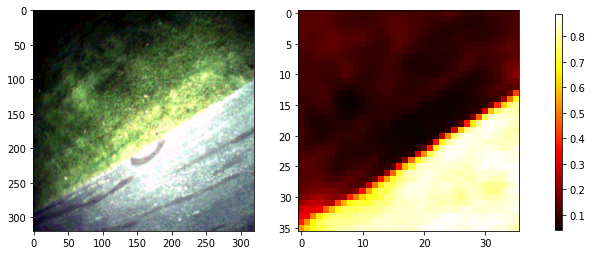

In [70]:
probs = fcn.predict(read_rgb('sample_images/siteD_CAM0087B.tiff'))

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(PIL.Image.open('sample_images/siteD_CAM0087B.tiff'))
im = ax[1].imshow(probs[0,:,:,1], cmap='hot')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)


### Sample image from different site not used in training data

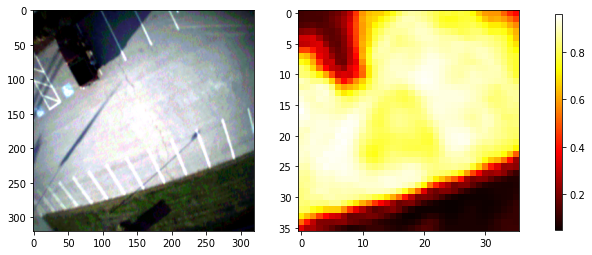

In [71]:
probs = fcn.predict(read_rgb('sample_images/siteC_CAM0289B.tiff'))

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(PIL.Image.open('sample_images/siteC_CAM0289B.tiff'))
im = ax[1].imshow(probs[0,:,:,1], cmap='hot')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)

In [72]:
fcn.save('land-fcn')

INFO:tensorflow:Assets written to: land-fcn\assets
